In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from services.machine_service import MachineService
from services.experiment_service import ExperimentService

######################################################################
# Needed functions for which I didn't find the right place. Probably to be moved to rawpy
def elastic_correction(stress, disp, k):
    """
    Apply elastic correction to displacement data.

    Parameters:
    stress (np.ndarray): The stress data array.
    disp (np.ndarray): The displacement data array.
    k (float or np.ndarray): The stiffness value (scalar or array).

    Returns:
    np.ndarray: Elastic corrected displacement data.
    """
    # Convert scalar k to an array if it is not already an array
    if np.isscalar(k):
        k = k
    else:
        k = k[:-1]

    # Increments in elastic distortion
    dload = (stress[1:] - stress[:-1]) / k
    # Increments in total displacement
    ddisp = disp[1:] - disp[:-1]
    # Subtract elastic distortion from total displacement
    ec_disp = np.hstack([0, np.cumsum(ddisp - dload)])
    return ec_disp

def detect_touch_point(force_readings, check_up2load=10):
    """
    Detects the touch point where the force readings consistently stay above the moving average.
    
    Parameters:
    - force_readings: [kN] The time series data of force readings.
    - check_up2load: [kN] touch point is searched in the segment before the first occurrence of this value
    Returns:
    - The index of the touch point.
    """
    min_list = []
    max_list = []
    average_list = []
    idx_lim = np.argmax(force_readings>check_up2load)
    force_readings = force_readings[:idx_lim] - force_readings[0]
    for N in range(1, len(force_readings)):
        min_list.append(np.min(force_readings[:N]))
        max_list.append(np.max(force_readings[:N]))
        average_list.append(np.mean(force_readings[:N]))
    
    for i in range(1, len(average_list)):
        if all(force_readings[j] > average_list[j] for j in range(i, len(average_list))):
            print(f"Touch point detected at index: {i}")
            return i + 1  # Return the index adjusted to the original data
    
    return -1  # Return -1 if no touch point is detected

########################################################################################
# Connect to database
ms = MachineService()
es = ExperimentService()

# Choose the experiment to analyze
experiment_id = 's0104sa05_F110_mus_F110_52'
machine_id = 'Brava2'
experiment_info = es.get_experiment_by_id(experiment_id)
experiment_date = experiment_info['Start_Datetime']
group_name = "ADC"     # the measurements in the tdms file are stored under this denominations

# ABBREVIATION CONVENTION
# v_{anything else} +> "vertical"
# h_{anything else} +> "horizontal"

# Fetch the centralized measurements (the ones coming from the VI)
v_load_measurements = es.get_centralized_measurements(experiment_id=experiment_id, group_name=group_name, channel_name= 'Vertical Load')
h_load_measurements = es.get_centralized_measurements(experiment_id, group_name=group_name, channel_name= 'Horizontal Load')
v_displacement_measurements = es.get_centralized_measurements(experiment_id, group_name=group_name, channel_name='Vertical Displacement')
h_displacement_measurements = es.get_centralized_measurements(experiment_id, group_name=group_name, channel_name='Horizontal Displacement')
time_measurements = es.get_centralized_measurements(experiment_id, group_name=group_name, channel_name='Time')

v_load_recorded = np.array(v_load_measurements['data'])
h_load_recorded = np.array(h_load_measurements['data'])
v_displacement_recorded = np.array(v_displacement_measurements['data'])
h_displacement_recorded = np.array(h_displacement_measurements['data'])
time_s = np.array(time_measurements['data'])
records_na = np.arange(len(time_s))     # same operation done in rawpy


MongoDB is running.
MongoDB is running.
Experiment s0104sa05_F110_mus_F110_52 found


In [41]:

# LOAD MEASUREMENTS:
# For the current implementation, you need to:
# 1) Fetch the "properties": these are for visualization scaling, not real calibration values!
# 2) Offset the recorded measurements (in volt) with the scaling properties
# 3) Pass the offsetted value to ms.apply_calibration(), that use the stored coefficients to provide the measures in kN
# If possible through a VI implementation, the actual coefficients from the calibration procedure should be
# recorded directly in the tdms file. 
v_visualization_slope = v_load_measurements['properties']['Slope']
v_intercept = v_load_measurements['properties']['Intercept']
h_visualization_slope = h_load_measurements['properties']['Slope']
h_intercept = h_load_measurements['properties']['Intercept']

v_offset = v_intercept/v_visualization_slope
h_offset= h_intercept/h_visualization_slope

v_load_volt = v_load_recorded + v_offset
h_load_volt = h_load_recorded + h_offset

v_load_kN = ms.apply_calibration(machine_id, 'Vertical', v_load_volt, experiment_date)
h_load_kN = ms.apply_calibration(machine_id, 'Horizontal', h_load_volt, experiment_date)


Applied calibration for piston Vertical in machine Brava2.
Applied calibration for piston Horizontal in machine Brava2.


1.1213430019602908
146.611
130.7459


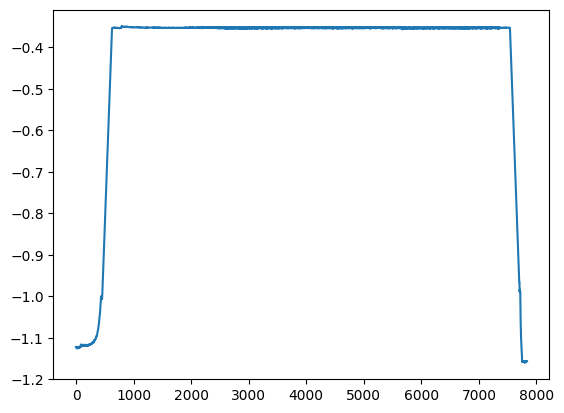

In [42]:
plt.plot(h_load_recorded)
print(h_offset)
print(h_intercept)
print(h_visualization_slope)

In [43]:

#### Gouge area ####
# This information can be retrieved from lateral blocks dimensions
# gouge_area = 0.0025 # m^2. It can be retrieved from the dimensions of the blocks
# Query for block dimensions
blocks = es.get_blocks(experiment_id=experiment_id)
if not blocks:
    # Add the blocks used in the experiment if it is not been done already
    es.add_block(experiment_id=experiment_id, block_id="paglialberi_1",position="left"),
    es.add_block(experiment_id=experiment_id, block_id="central_1",position="central"),
    es.add_block(experiment_id=experiment_id, block_id="paglialberi_2",position="right")
    blocks = es.get_blocks(experiment_id=experiment_id)

# Calculate the gouge area
lateral_block_dimensions = blocks[0]["dimensions"]
gouge_area_mm2 = lateral_block_dimensions['width'] * lateral_block_dimensions['height']  
gouge_area_m2 = 1e-6 * gouge_area_mm2    # covnersion to [m^2]

#### From Vertical load to shear stress ###
#### This is the point at which the ram contacted the blocks and load shear loading began
#### So far it is chosen looking at the plot, but it must be automatize too. AUTOMATION DONE
# v_touch_point = 2808
v_touch_point = detect_touch_point(v_load_kN, check_up2load=10)
# v_load = v_load + 0.044 #[kN]  # add in force from the central block due to gravity
v_load_kN = v_load_kN - v_load_kN[v_touch_point]              # remove noise before load is applied
v_load_kN[:v_touch_point]= v_load_kN[:v_touch_point]*0
v_load_kN = np.where(v_load_kN > 0, v_load_kN, 0)

shear_stress_MPa = 1e-3 * v_load_kN/(2*gouge_area_m2)      # why that "2" Lo sforzo di taglio va suddiviso sui due gouges, non cosi quello normale!!!


#############  normal load ############ 
#### Normal load is applied at record number = h_touch_point
# h_touch_point = 234
h_touch_point = detect_touch_point(h_load_kN, check_up2load=10)
# zero the data
h_load_kN = h_load_kN - h_load_kN[h_touch_point]
# remove noise before load is applied 
h_load_kN[:h_touch_point] = h_load_kN[:h_touch_point]*0
h_load_kN = np.where(h_load_kN > 0, h_load_kN, 0)

normal_stress_MPa =  1e-3 * h_load_kN/(gouge_area_m2)

Experiment s0104sa05_F110_mus_F110_52 found
MongoDB is running.
block paglialberi_1 found
block central_1 found
block paglialberi_2 found
Touch point detected at index: 2298
Touch point detected at index: 65


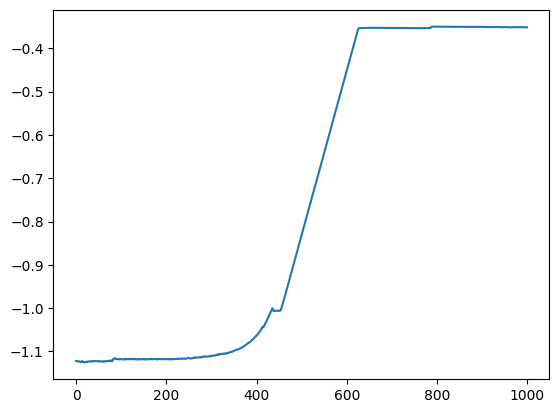

In [44]:
plt.plot(h_load_recorded[:1000])

In [46]:
####  DISPLACEMENT MEASUREMENTS
# From vertical displacement to load point displacement
v_slope = v_displacement_measurements['properties']['Slope']
v_intercept = v_displacement_measurements['properties']['Intercept']
v_displacement_mum = v_slope * v_displacement_recorded + v_intercept
v_displacement_mm = 1e-3 * v_displacement_mum
load_point_disp_mm = v_displacement_mm - v_displacement_mm[v_touch_point] # [mum]
load_point_disp_mm[:v_touch_point] = load_point_disp_mm[:v_touch_point]*0

# Elastic correction for the stretch of the vertical frame # 
v_stiffness_constant = 166.801 #[MPa/mm]         # calibration from loading and unloading cycles on steel: linear approx
v_stiffness = ms.apply_stiffness_correction(machine_id, 'Vertical', v_load_kN, experiment_date)

# "Elastic corrected" displacement
load_point_disp_corrected_mm = elastic_correction(v_load_kN, load_point_disp_mm, v_stiffness) 
load_point_disp_corrected_mm_old = elastic_correction(shear_stress_MPa, load_point_disp_mm, v_stiffness_constant)

### From horizontal displacement to layer thickness
h_slope = h_displacement_measurements['properties']['Slope']
h_intercept = h_displacement_measurements['properties']['Intercept']
h_displacement_mum = h_slope * h_displacement_recorded + h_intercept
h_displacement_mm = 1e-3 * h_displacement_mum

# Carolina, correzione iniziale serve nel caso carico normale variabile e se necessario valore assoluto layer thickNess (tipo, fase iniziale. O simulazione onde, per l'appunto)
# Elastic correction for the stretch of the horizontal frame #
h_stiffness_constant = 125.363 #[MPa/mm]              # calibration from loading and unloading cycles on steel: linear approx
h_stiffness = ms.apply_stiffness_correction(machine_id, 'Horizontal', h_load_kN, experiment_date)
h_displacement_corrected_mm = elastic_correction(normal_stress_MPa, -h_displacement_mm,h_stiffness)   # why "-"? So that compaction is negative
h_displacement_corrected_mm_old = elastic_correction(normal_stress_MPa, -h_displacement_mm,h_stiffness_constant)

######################################################################
########## 5. Calculate layer thickNess: MUST STANDARDIZE!!! ##########################
##################################################################### 
# insert rec number at which layer thickness was measured
rec_lt = h_touch_point
# insert calculated value at that point
val_lt = 5    # [mm]
###########################################################
# zero data
layer_thickness_corrected_mm = h_displacement_corrected_mm - h_displacement_corrected_mm[rec_lt]
layer_thickness_corrected_mm_half = layer_thickness_corrected_mm/2
layer_thickness_corrected_mm1 = layer_thickness_corrected_mm_half + val_lt

layer_thickness_corrected_mm_old = h_displacement_corrected_mm_old - h_displacement_corrected_mm_old[rec_lt]
layer_thickness_corrected_mm_old_half = layer_thickness_corrected_mm_old/2
layer_thickness_corrected_mm_old1 = layer_thickness_corrected_mm_old_half + val_lt


Applied stiffness correction for piston Vertical in machine Brava2.
Applied stiffness correction for piston Horizontal in machine Brava2.


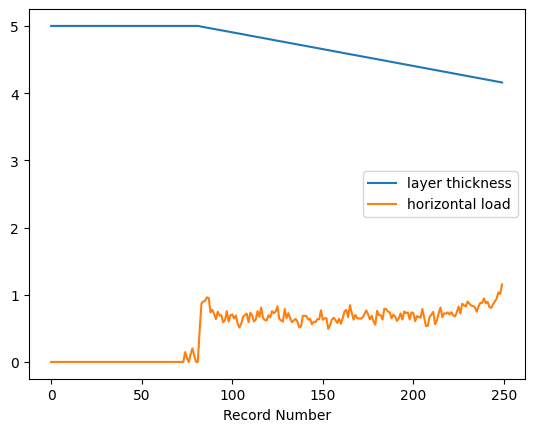

In [47]:
# plt.plot(h_displacement_mm[:1000] )
# plt.plot(h_displacement_corrected_mm[:1000] )
idx = 250
# plt.plot(h_displacement_mm[:idx], label="horizontal displacement")
plt.plot(layer_thickness_corrected_mm1[:idx], label="layer thickness")

plt.plot(h_load_kN[:idx], label="horizontal load")
# plt.plot(load_point_disp_mm[:6000], label="vertical displacement")
# plt.plot(v_load_kN[:6000], label="vertical load")
plt.xlabel("Record Number")
plt.legend()

In [48]:
# # default unit is [mm]
# rgt_lt_mm = rp.rgt(load_point_disp_mm,layer_thickness_corrected_mm1)     # remove geometrical thinning
# # 6. Calculate friction 
epsilon = 1e-7 #add a small number to normal stress so that we aren't dividing by 0 anywhere to calculate mu 
friction_na = shear_stress_MPa/(normal_stress_MPa + epsilon)

# # 7. Calculate shear strain. Marco dice indifferente lt o quella corretta per geometrical thinning
# shear_strain_na = rp.shear_strain(ec_disp_mm,layer_thickness_corrected_mm1)


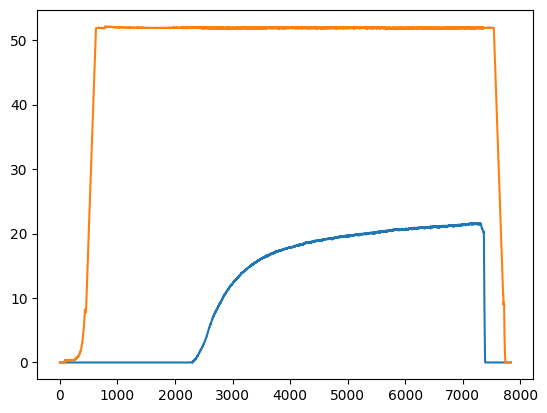

In [49]:
plt.plot(shear_stress_MPa)
plt.plot(normal_stress_MPa)

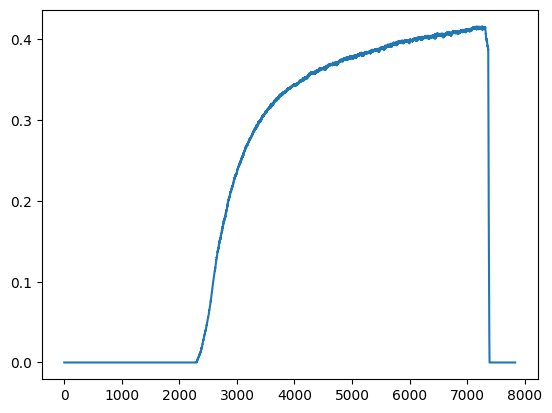

In [50]:
plt.plot(friction_na)